# Optimized Dynamic Slotting with Forecast & Turnover

## 1. Imports & Setup

In [1]:

import math
import random
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


## 2. Data Loading & Preprocessing

In [2]:

DATA_PATH = Path("logistics_dataset.csv")
df = pd.read_csv(DATA_PATH)

# Preprocessing
zones = sorted(df["zone"].unique())
grid_w = math.ceil(math.sqrt(len(zones)))
grid_h = math.ceil(len(zones) / grid_w)
zone_positions = {zone: (idx // grid_w, idx % grid_w) for idx, zone in enumerate(zones)}
staging_point = np.array([grid_h / 2, grid_w / 2])

zone_totals = df.groupby("zone")["daily_demand"].sum().to_dict()
zone_capacity = {z: max(total * 1.15, total + 25) for z, total in zone_totals.items()}

def travel_distance(zone):
    coord = np.array(zone_positions.get(zone, (0, 0))).astype(float)
    return float(np.linalg.norm(coord - staging_point))

df["travel_distance"] = df["zone"].map(travel_distance)
df["zone_demand_total"] = df["zone"].map(zone_totals)
df["zone_capacity"] = df["zone"].map(zone_capacity)
df["zone_load_ratio"] = df["zone_demand_total"] / df["zone_capacity"]

print("Data Loaded and Preprocessed.")
df.head()


Data Loaded and Preprocessed.


,item_id,category,stock_level,reorder_point,reorder_frequency_days,lead_time_days,daily_demand,demand_std_dev,item_popularity_score,storage_location_id,...,total_orders_last_month,turnover_ratio,layout_efficiency_score,last_restock_date,forecasted_demand_next_7d,KPI_score,travel_distance,zone_demand_total,zone_capacity,zone_load_ratio
0,ITM10000,Pharma,283,21,4,4,49.85,1.56,0.43,L82,...,700,3.33,0.33,2024-02-17,184.37,0.556,1.000000,18999.35,21849.2525,0.869565
1,ITM10001,Automotive,301,52,9,6,23.34,2.55,0.69,L15,...,736,10.36,0.98,2024-10-01,221.94,0.723,1.414214,21182.12,24359.4380,0.869565
2,ITM10002,Groceries,132,60,11,8,37.69,3.15,0.62,L4,...,814,14.32,0.87,2024-04-07,53.85,0.680,1.000000,18999.35,21849.2525,0.869565
3,ITM10003,Automotive,346,46,13,5,33.69,2.79,0.21,L95,...,994,2.08,0.29,2024-01-27,92.04,0.488,1.414214,21182.12,24359.4380,0.869565
4,ITM10004,Automotive,49,55,4,6,49.58,5.23,0.31,L36,...,299,5.65,0.96,2024-05-17,194.58,0.670,0.000000,21421.50,24634.7250,0.869565


## 3. Helper Functions

In [3]:

@dataclass
class SlottingMetrics:
    baseline_time: float
    new_time: float
    travel: float
    move_cost: float
    reward: float
    demand: float
    layout_score: float
    item_id: str
    old_zone: str
    new_zone: str
    time_gain_seconds: float
    value_gain: float
    net_value: float

SLOT_VALUE_PER_SECOND = 0.22
OVERLOAD_WEIGHT = 55.0
UTILIZATION_SOFT_LIMIT = 0.92
NEGATIVE_MOVE_PENALTY = 25.0
MIN_TIME_GAIN_SECONDS = 45.0

def predict_picking_time(row: pd.Series, target_zone: str, zone_loads: dict, capacities: dict) -> float:
    base_time = row["picking_time_seconds"]
    load_ratio = zone_loads.get(target_zone, 0.0) / max(capacities.get(target_zone, 1), 1)
    travel_factor = row["travel_distance"] if target_zone == row["zone"] else travel_distance(target_zone)
    layout_bonus = max(0.0, row["layout_efficiency_score"] - 0.5)
    congestion_penalty = 1 + 0.45 * min(load_ratio, 2.0)
    travel_penalty = 8 + 6 * travel_factor
    time = base_time * congestion_penalty + travel_penalty - layout_bonus * 6
    return max(time, base_time * 0.5)


## 4. Optimized Environment (Forecast & Turnover Integrated)

In [4]:

class ZoneSlottingEnv:
    def __init__(self, frame: pd.DataFrame, zones: list[str], capacities: dict[str, float], move_cost_base: float = 8.0):
        self.frame = frame.reset_index(drop=True)
        self.zones = zones
        self.capacities = capacities
        self.action_space = len(zones)
        self.move_cost_base = move_cost_base
        self.reset()

    def reset(self):
        self.items = self.frame.sample(frac=1.0, random_state=None).reset_index(drop=True)
        self.ptr = 0
        self.zone_loads = {z: zone_totals.get(z, 0.0) for z in self.zones}
        self.current_row = self.items.iloc[self.ptr]
        return self._state_index(self._observe(self.current_row))

    def _observe(self, row: pd.Series):
        # New Feature: Forecast Bin (replacing simple demand bin)
        # Bins: <50, 50-150, 150-300, >300
        forecast_bin = np.digitize([row["forecasted_demand_next_7d"]], [50, 150, 300])[0]
        
        # New Feature: Turnover Bin
        # Bins: <4, 4-8, 8-12, >12
        turnover_bin = np.digitize([row["turnover_ratio"]], [4, 8, 12])[0]
        
        load_ratio = self.zone_loads.get(row["zone"], 0.0) / max(self.capacities.get(row["zone"], 1), 1)
        load_bin = np.digitize([load_ratio], [0.6, 0.9, 1.1])[0]
        
        travel_bin = np.digitize([row["travel_distance"]], [1.0, 2.5, 4.0])[0]
        
        return (forecast_bin, turnover_bin, load_bin, travel_bin)

    def _state_index(self, state_tuple):
        f, tu, l, tr = state_tuple
        # f(4) * tu(4) * l(4) * tr(4)
        return f + 4 * tu + 4 * 4 * l + 4 * 4 * 4 * tr

    @property
    def state_space(self):
        return 4 * 4 * 4 * 4

    def step(self, action: int):
        row = self.current_row
        target_zone = self.zones[action]
        old_zone = row["zone"]
        baseline_time = predict_picking_time(row, old_zone, self.zone_loads, self.capacities)

        original_loads = dict(self.zone_loads)
        updated_loads = dict(original_loads)
        updated_loads[old_zone] = max(0.0, updated_loads.get(old_zone, 0.0) - row["daily_demand"])
        updated_loads[target_zone] = updated_loads.get(target_zone, 0.0) + row["daily_demand"]

        new_time = predict_picking_time(row, target_zone, updated_loads, self.capacities)
        move_cost = 0.0 if target_zone == old_zone else self.move_cost_base * (1 + row["stock_level"] / 200)

        time_gain = baseline_time - new_time
        time_gain_seconds = time_gain * row["daily_demand"]
        value_gain = time_gain_seconds * SLOT_VALUE_PER_SECOND

        capacity_new = max(self.capacities.get(target_zone, updated_loads[target_zone]), 1)
        utilization_new = updated_loads[target_zone] / capacity_new
        overload_penalty = OVERLOAD_WEIGHT * max(utilization_new - 1.0, 0.0) * row["daily_demand"]
        soft_penalty = 12.0 * max(utilization_new - UTILIZATION_SOFT_LIMIT, 0.0) * row["daily_demand"]

        raw_net_value = value_gain - move_cost - overload_penalty - soft_penalty

        move_accepted = (raw_net_value > 0) and (time_gain_seconds > MIN_TIME_GAIN_SECONDS)

        if move_accepted:
            self.zone_loads = updated_loads
            net_value = raw_net_value
            reward = net_value
        else:
            self.zone_loads = original_loads
            target_zone = old_zone
            new_time = baseline_time
            move_cost = 0.0
            time_gain_seconds = 0.0
            value_gain = 0.0
            net_value = 0.0
            reward = raw_net_value - NEGATIVE_MOVE_PENALTY

        metrics = SlottingMetrics(
            baseline_time=baseline_time,
            new_time=new_time,
            travel=travel_distance(target_zone),
            move_cost=move_cost,
            reward=reward,
            demand=row["daily_demand"],
            layout_score=row["layout_efficiency_score"],
            item_id=row["item_id"],
            old_zone=old_zone,
            new_zone=target_zone,
            time_gain_seconds=time_gain_seconds,
            value_gain=value_gain,
            net_value=net_value,
        )

        self.ptr += 1
        done = self.ptr >= len(self.items)
        if not done:
            self.current_row = self.items.iloc[self.ptr]
            next_state = self._observe(self.current_row)
            next_state_idx = self._state_index(next_state)
        else:
            next_state_idx = 0

        return next_state_idx, reward, done, metrics


## 5. Q-Learning Agent

In [5]:

class SlottingQLearner:
    def __init__(self, state_space: int, action_space: int, alpha: float = 0.12, gamma: float = 0.9):
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = np.zeros((state_space, action_space))

    def act(self, state_idx: int, epsilon: float) -> int:
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_space)
        return int(np.argmax(self.q_table[state_idx]))

    def update(self, state_idx: int, action: int, reward: float, next_state_idx: int, done: bool):
        best_next = 0.0 if done else np.max(self.q_table[next_state_idx])
        td_target = reward + self.gamma * best_next
        td_error = td_target - self.q_table[state_idx, action]
        self.q_table[state_idx, action] += self.alpha * td_error


## 6. Training

Starting Training...
Episode 100/1000 - Last Reward: -123683.28, Epsilon: 0.545
Episode 200/1000 - Last Reward: -120601.12, Epsilon: 0.330
Episode 300/1000 - Last Reward: -119664.50, Epsilon: 0.200
Episode 400/1000 - Last Reward: -115997.93, Epsilon: 0.121
Episode 500/1000 - Last Reward: -115067.71, Epsilon: 0.073
Episode 600/1000 - Last Reward: -116238.04, Epsilon: 0.050
Episode 700/1000 - Last Reward: -114177.67, Epsilon: 0.050
Episode 800/1000 - Last Reward: -112896.55, Epsilon: 0.050
Episode 900/1000 - Last Reward: -113212.96, Epsilon: 0.050
Episode 1000/1000 - Last Reward: -114408.57, Epsilon: 0.050
Training Complete.


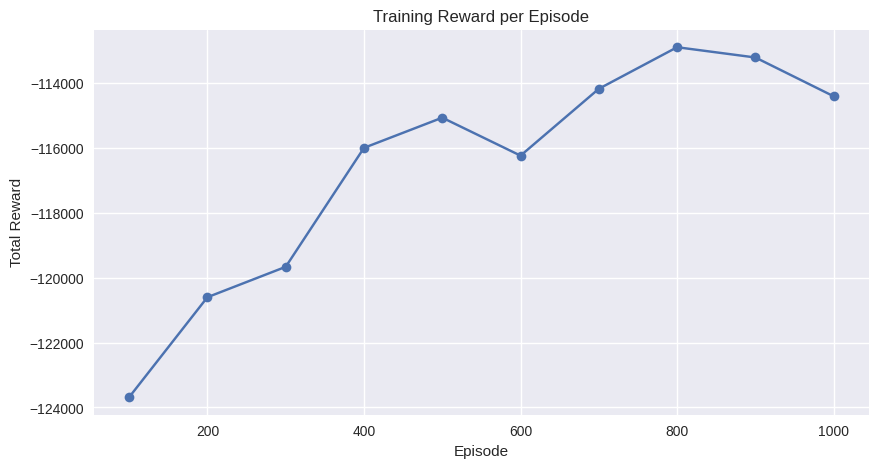

In [6]:

# Setup Environment and Agent
env = ZoneSlottingEnv(df, zones, zone_capacity)
agent = SlottingQLearner(env.state_space, env.action_space)

# Training Parameters
episodes = 1000
epsilon = 0.9
epsilon_decay = 0.995
min_epsilon = 0.05

training_log = []

print("Starting Training...")
for episode in range(episodes):
    state_idx = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.act(state_idx, epsilon)
        next_state_idx, reward, done, _ = env.step(action)
        agent.update(state_idx, action, reward, next_state_idx, done)
        state_idx = next_state_idx
        total_reward += reward
        
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes} - Last Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")
        training_log.append({"episode": episode + 1, "reward": total_reward})

print("Training Complete.")

# Plot Training Progress
log_df = pd.DataFrame(training_log)
plt.figure(figsize=(10, 5))
plt.plot(log_df["episode"], log_df["reward"], marker='o')
plt.title("Training Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()


## 7. Evaluation Logic

In [7]:

def baseline_policy(state_idx, env):
    # Policy: Keep item in its current zone
    current_zone = env.current_row["zone"]
    return env.zones.index(current_zone)

def rl_policy(state_idx, env):
    # Policy: Greedy action from Q-table
    return agent.act(state_idx, 0.0)

def apply_slotting_policy(frame: pd.DataFrame, policy_fn):
    env = ZoneSlottingEnv(frame, zones, zone_capacity)
    state_idx = env.reset()
    
    records = []
    done = False
    
    while not done:
        action = policy_fn(state_idx, env)
        next_state_idx, reward, done, metrics = env.step(action)
        records.append({
            "item_id": metrics.item_id,
            "old_zone": metrics.old_zone,
            "new_zone": metrics.new_zone,
            "baseline_time": metrics.baseline_time,
            "new_time": metrics.new_time,
            "travel_old": travel_distance(metrics.old_zone),
            "travel_new": metrics.travel,
            "demand": metrics.demand,
            "move_cost": metrics.move_cost,
            "time_gain_seconds": metrics.time_gain_seconds,
            "net_value": metrics.net_value,
        })
        state_idx = next_state_idx
        
    return pd.DataFrame(records)

def summarize_assignments(assignments: pd.DataFrame):
    if assignments.empty:
        return {}
        
    avg_pick_new = np.average(assignments["new_time"], weights=assignments["demand"])
    avg_pick_baseline = np.average(assignments["baseline_time"], weights=assignments["demand"])
    avg_travel_new = np.average(assignments["travel_new"], weights=assignments["demand"])
    avg_travel_old = np.average(assignments["travel_old"], weights=assignments["demand"])
    
    total_time_gain = assignments["time_gain_seconds"].sum()
    total_net_value = assignments["net_value"].sum()
    total_moves = (assignments["old_zone"] != assignments["new_zone"]).sum()
    
    return {
        "avg_picking_time_new": avg_pick_new,
        "avg_picking_time_baseline": avg_pick_baseline,
        "avg_travel_new": avg_travel_new,
        "avg_travel_old": avg_travel_old,
        "total_time_gain_seconds": total_time_gain,
        "total_net_value": total_net_value,
        "total_moves": total_moves
    }


## 8. Results & Visualization

Running Evaluation...
                             Baseline    RL Policy
avg_picking_time_new       145.183443   145.149922
avg_picking_time_baseline  145.183443   145.187008
avg_travel_new               0.844808     0.840587
avg_travel_old               0.844808     0.844808
total_time_gain_seconds      0.000000  3022.302453
total_net_value              0.000000   152.026540
total_moves                  0.000000    38.000000


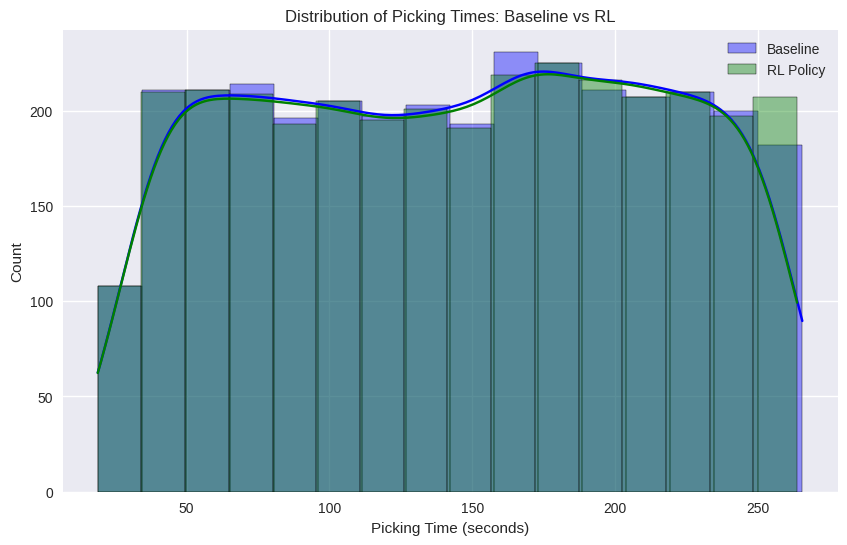

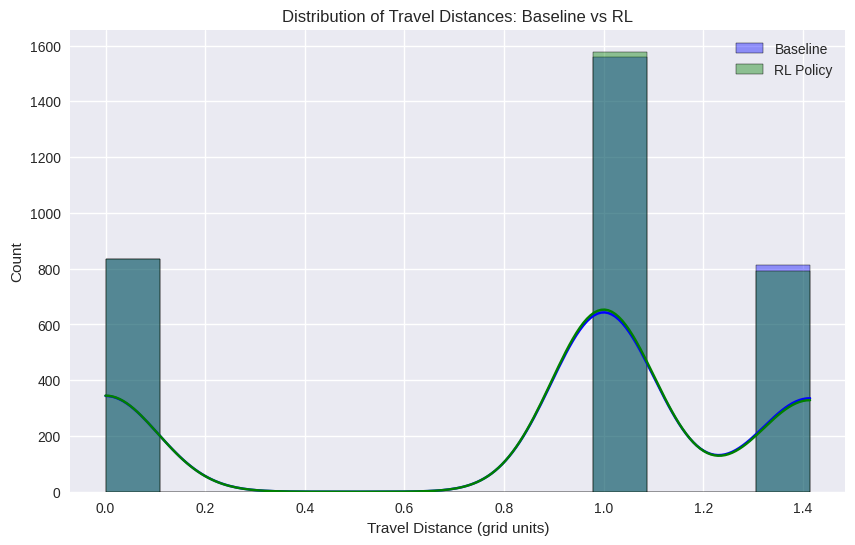

In [8]:

print("Running Evaluation...")
# Run Baseline
baseline_df = apply_slotting_policy(df, baseline_policy)
baseline_summary = summarize_assignments(baseline_df)

# Run RL Policy
rl_df = apply_slotting_policy(df, rl_policy)
rl_summary = summarize_assignments(rl_df)

# Compare
comparison = pd.DataFrame([baseline_summary, rl_summary], index=["Baseline", "RL Policy"])
print(comparison.T)

# Visualization: Picking Time Distribution
plt.figure(figsize=(10, 6))
sns.histplot(baseline_df["baseline_time"], color="blue", label="Baseline", kde=True, alpha=0.4)
sns.histplot(rl_df["new_time"], color="green", label="RL Policy", kde=True, alpha=0.4)
plt.title("Distribution of Picking Times: Baseline vs RL")
plt.xlabel("Picking Time (seconds)")
plt.legend()
plt.show()

# Visualization: Travel Distance Distribution
plt.figure(figsize=(10, 6))
sns.histplot(baseline_df["travel_old"], color="blue", label="Baseline", kde=True, alpha=0.4)
sns.histplot(rl_df["travel_new"], color="green", label="RL Policy", kde=True, alpha=0.4)
plt.title("Distribution of Travel Distances: Baseline vs RL")
plt.xlabel("Travel Distance (grid units)")
plt.legend()
plt.show()
